# European Parliament Twitter activities MEP 1.0

We will investigate a dataset of tweets made by Members of the European Parliament. We will use data collected by Darko Cherepnalkoski, Andreas Karpf, Igor Mozetič, and Miha Grčar for their paper [Cohesion and Coalition Formation in the European Parliament: Roll-Call Votes and Twitter Activities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166586)

This assignment is based on an original assignment by Ioannis Pavlopoulos (postdoc researcher) and Vasiliki Kougia (PhD candidate at AUEB).

Find the github repo [here]( ionpetro/Clustering-and-Classification-of-MEPs-Tweets)

---

> Ioannis (Ion) Petropoulos, 8160107 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> ionpetro@gmail.com

Let's get started, by importing some libraries and reading the csv

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mep = pd.read_csv('data/retweets.csv')

In [3]:
mep.shape

(26133, 21)

In [4]:
mep.columns

Index(['origUserId', 'origUserScreenName', 'origMepId', 'origMepName',
       'origMepGroupId', 'origMepGroupShort', 'origMepCountryId',
       'origMepCountryShort', 'retweetUserId', 'retweetUserScreenName',
       'retweetMepId', 'retweetMepName', 'retweetMepGroupId',
       'retweetMepGroupShort', 'retweetMepCountryId', 'retweetMepCountryShort',
       'origCreatedAt', 'origTweetId', 'retweetCreatedAt', 'retweetTweetId',
       'lang'],
      dtype='object')

## Data Preparation

We are only keeping the tweets written in English

In [6]:
mep = mep.loc[mep.lang == 'en']

Let's connect to twitter and grab our keys. The API keys were saved as environmental variables for security reasons 

In [78]:
import tweepy
import os
from dotenv import load_dotenv

load_dotenv()

CONSUMER_TOKEN = os.getenv('CONSUMER_TOKEN')
CONSUMER_SECRET = os.getenv('CONSUMER_SECRET')
auth = tweepy.OAuthHandler(CONSUMER_TOKEN, CONSUMER_SECRET)

Let's see how the dataset looks like

In [79]:
mep.head()

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en
12,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en
13,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en


We need all the tweetIDs in a list so we can hit the API and ask for the original tweet text. So let's do it!

In [80]:
origTweetList = mep.origTweetId.tolist()

In [81]:
try:
    redirect_url = auth.get_authorization_url()
    print('API responded!')
except tweepy.TweepError:
    print('Error! Failed to get request token.')

API responded!


We will send API requests in batches of 100s, so we will use a python script for that.

In [82]:
# based on https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

import time

t0 = time.time()

def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range((tweet_count // 100) + 1):
            # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            full_tweets.extend(
                api.statuses_lookup(id_=tweet_IDs[i * 100:end_loc])
            )  
        return full_tweets
    except tweepy.TweepError:
        print('Something went wrong, quitting...')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# do whatever it is to get por.TweetID - the list of all IDs to look up

results = lookup_tweets(origTweetList, api)

final_dic = {}

t1 = time.time()
total = t1-t0
print(total)

137.40496301651


We will save the result on a python dictionary, where key is the tweet id and value is the text

In [83]:
for tweet in results:
    if tweet:
        final_dic[tweet.id] = tweet.text

We can create a dataframe to get a clear understanding of what we extracted

In [85]:
tweet_text = pd.DataFrame.from_dict(final_dic, orient='index', columns=['tweetText'])
tweet_text.head()

,tweetText
519050739642286080,Lord Hill's written answers to EP are now on m...
519139901359783936,Our @SebDance asks @ABratusek about global cli...
518024241024073728,I write for @LabourList Tory threat to Court o...
519109106272317440,"“@Ashleyfoxmep: and named her party ""the Allia..."
518721908951769088,Good luck to @TheProgressives in Bulgaria toda...


We can merge the tweet texts with the original dataframe

In [18]:
mepExt = pd.merge(mep, tweet_text, left_on='origTweetId', right_index=True, how='inner')

* We can observe that there are some Political Groups that have tweeted less than 50 times, which is not enough information for those
* We are getting rid of them

In [19]:
group = mepExt.groupby('origMepGroupShort').count()
groupFiltered = group.loc[group.origUserId > 50]
mepExt = mepExt.loc[mepExt.origMepGroupShort.isin(list(groupFiltered.index))]

The final result is the following

In [87]:
mepExt.head()

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
5,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
11,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
12,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
13,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."


Since the data collection using the Twitter API needs approx 300 secs, we are going to extract the cleaned dataset, so we can save some time.

In [89]:
export = mepExt.to_csv('data/fullRetweets.csv', index = None, header=True)

## Clustering

* We are going to use k-means to cluster the tweets based on their text
* Let's first import all the libraries we are going to use

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

fullRetweets = pd.read_csv('data/FullRetweets.csv')

In [58]:
import wordcloud
import matplotlib
import PIL

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction import text 


# another set of stopwords

from nltk.corpus import stopwords
import nltk
import sklearn as sk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Since our dataset has retweets, that means there are duplicates, which we have to drop

In [60]:
clean_text = fullRetweets.tweetText.drop_duplicates()

We can create our **corpus**, a list of documents (tweets)

In [61]:
corpus = list(clean_text)

In [83]:
# We have to add some stop words that are relevant to the topic
my_additional_stop_words = ['http', 'https', 'amp', 'timmermans', 'timkirkhopemep', 'mep', 'meps',
                            'etuc_ces', 'today', 'tonight', 'tomorrow', 'kurdish', 'europe',
                            'eu', 'ep', 'european', 'parliament', 'eu_commission', 'europarl_en']

stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

We want to create a vectorizer, since kmeans can not operate with text.

In [84]:
my_stop_words = set(stopwords.words('english')) 
vectorizer = CountVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words = stop_words)
X = vectorizer.fit_transform(corpus)

# The TfidfVectorizer is not giving good results, so it's deactivated
# vectorizer2 = TfidfVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words='english')
# X2 = vectorizer2.fit_transform(corpus)

* Now that we have created the Vectorizer, we need to find the number of clusters. For that, we will use **Elbow Method** and **Silhouette Visualizer** in order to conclude
* We start with the **Elbow Method** from **Yellow Brick** library

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

scaler.fit(X)

StandardScaler(copy=True, with_mean=False, with_std=True)

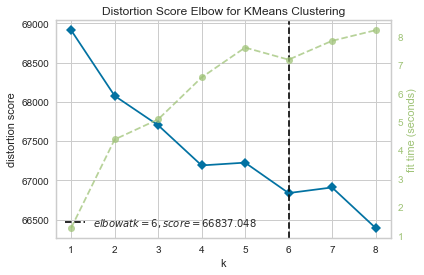

In [88]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,9))

visualizer.fit(X)
visualizer.show()

* The elbow method gives us k = 6 as the optimal number of clusters.
* Let's also try the **Silhouette Visualizer**

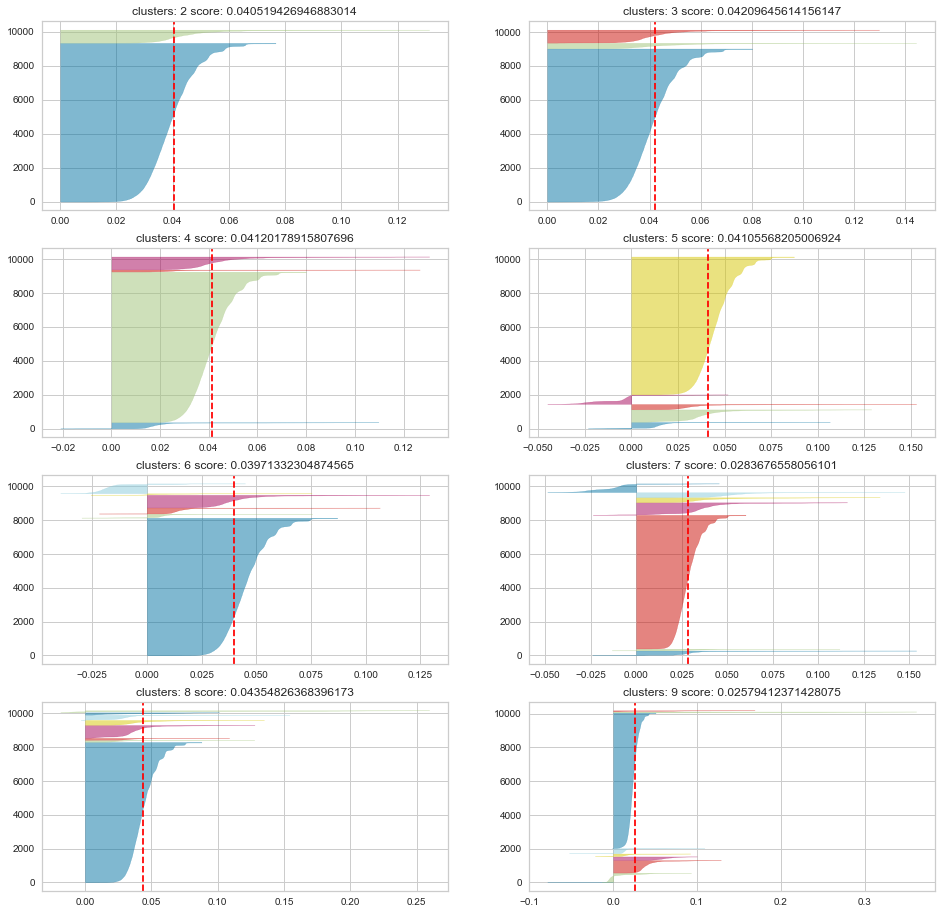

In [89]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

We can sort the results to find the number of clusters with the highest **silhouette score**

In [90]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(8, 0.04354826368396173),
 (3, 0.04209645614156147),
 (4, 0.04120178915807696),
 (5, 0.04105568205006924),
 (2, 0.040519426946883014),
 (6, 0.03971332304874565),
 (7, 0.0283676558056101),
 (9, 0.02579412371428075)]

We will go with the Silhouette Score, and see what we get

In [95]:
#According to Silhouette
kmeans = KMeans(n_clusters=8, random_state=32).fit(X)

#we want to predict the labels for each word
cluster_labels = kmeans.fit_predict(X)

metrics.silhouette_score(X, labels=cluster_labels)

0.039550669183120925

The silhouette score is quite low but this is not unreasonable when we have these many dimensions

In [97]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(8):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ukip labour nhs party people just immigration policy great debate
Cluster 1: trade ttip free union need deal deals great jude_kd intergroup
Cluster 2: ttip isds vote debate labour public eurolabour good malmstromeu eppgroup
Cluster 3: migration policy ukip net crisis asylum need eppgroup cameron mass
Cluster 4: greece tsipras greek euro eppgroup eurozone people yes imf new
Cluster 5: eppgroup great people good new meeting need support debate just
Cluster 6: vote ukip labour yes people report majority debate just leave
Cluster 7: uk ukip labour brexit migrants govt good steel leave people


* **Cluster 7** is reffering to brexit (or the political situation in UK)
* **Cluster 2** is probably talking about international issues (ttip - isds)
* **Cluster 3** is talking about a migration crisis in the UK
* **Cluster 6** is reffering to the UK Independance Party
* **Cluster 4** is addressing the political situation in Greece

Using the **InterclusterDistance** we visualize the results to see some clear clusters

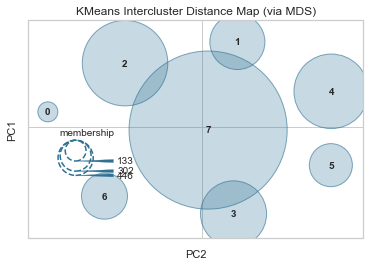

In [99]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(8)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The different clusters seems to be clearly separated, and that's good

## Classification

The next process we are going to run to the data is Classification. The target column is the political party and the training feautures are the tweet's text.

In [2]:
#import the libraries required for the classification

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import sklearn as sk

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

We want to read again the ```fullRetweets dataset``` and keep only the columns needed for the classification

In [4]:
fullRetweets = pd.read_csv('data/FullRetweets.csv')

classif_tweets = fullRetweets[['tweetText', 'origMepGroupShort']]

In [5]:
#having retweets, we remove the duplicate texts
classif_tweets = classif_tweets.drop_duplicates()

In [6]:
classif_tweets.head()

,tweetText,origMepGroupShort
0,Euro Parliament votes overwhelmingly to reject...,EFDD
1,"US have one currency, one Central Bank and one...",S&D
2,More jobs for young people is my top priority ...,S&D
3,"Vote #Labour, get Tory. Vote Tory, get Labour....",EFDD
5,Answering my question in ECR Group J-C Juncker...,ECR


* This is what we have right now
* Let's first investigate the balance of different tweets between the different political parties.

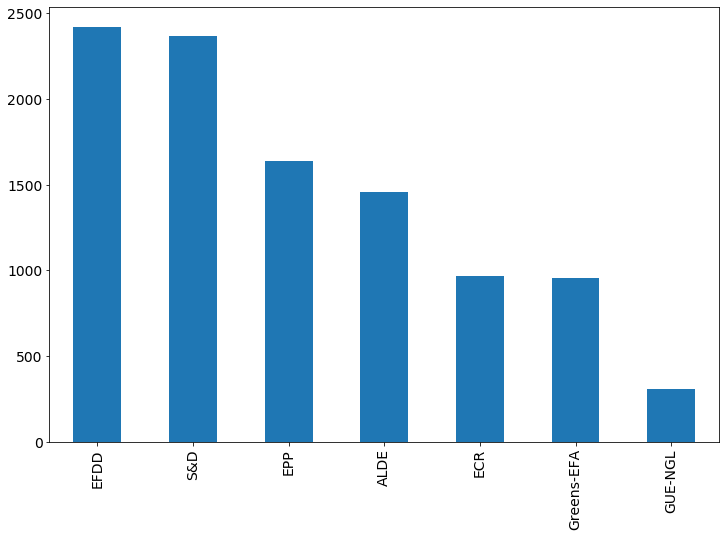

In [7]:
classif_tweets.origMepGroupShort.value_counts().plot(kind='bar', figsize=(12,8), fontsize=14)

* We notice that the classes are inbalanced but we will try to get some outcomes without resampling, ensembling etc
* Let's create a ```dummy classifier``` who's score will be our threshold

In [8]:
X = classif_tweets.tweetText
y = classif_tweets.origMepGroupShort
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)

array(['EFDD', 'EFDD', 'EFDD', ..., 'EFDD', 'EFDD', 'EFDD'], dtype='<U4')

In [10]:
dummy_clf.score(X, y)

0.23935854286279945

* If we don't surpass 23% accurancy, then there is no point in what we are trying to do
* In order to have more chances of getting a good result, we will do some work to clear the data as good as possible

## Further cleaning

In [12]:
# import nltk library for text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

* We have to create a **bag of words** is which we will do the classification

The methods that we are going to apply to the data are:

* Remove Stepwords
* Remove Punctuation
* Remove URLS
* Lemmatize

In [13]:
### Remove Stepwords

STOPWORDS = set(stopwords.words('english'))
my_additional_stop_words = ['http', 'https', 'amp', 'timmermans',
                            'timkirkhopemep', 'etuc_ces', 'europe', 'eu', 'ep',
                            'european', 'parliament', 'today', 'tonight', 'tomorrow', 'morning',
                           'see', 'want']
STOPWORDS.update(my_additional_stop_words)
def stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

classif_tweets.tweetText = classif_tweets.tweetText.apply(lambda x: stopwords(x))

In [14]:
import string
import re

### Remove Punctuation

def remove_punctuation(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc

classif_tweets['tweetText'] = classif_tweets['tweetText'].apply(lambda x: remove_punctuation(x)) 

In [15]:
### Remove URLS

def remove_urls(text):
    no_url = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return no_url
classif_tweets['tweetText'] = classif_tweets['tweetText'].apply(lambda x: remove_urls(x)) 

We will try both Lemmatizer and Stemming to compare the results on the models and conclude

In [16]:
tokenizer = RegexpTokenizer(r'\w+')
classif_tweets.tweetText = classif_tweets.tweetText.apply(lambda x: tokenizer.tokenize(x.lower()))

In [17]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

classif_tweets.tweetText = classif_tweets.tweetText.apply(lambda x: word_lemmatizer(x))

On Naive Bayes we got 0.52 accurancy

Let's also try Stemming (which is more aggressive)

In [20]:
# Deactivated Stemmer since it gives us worse results

# stemmer = PorterStemmer()

# def word_stemmer(text):
#     stem_text = " ".join([stemmer.stem(i) for i in text])
#     return stem_text

# classif_tweets.tweetText = classif_tweets.tweetText.apply(lambda x: word_stemmer(x))

Stemming got us a lower accurancy on Naive Bayes model, so we are going to use **lemmatizer**. This is what we got.

In [21]:
classif_tweets.tweetText

0        euro parliament vote overwhelmingly reject act...
1        u one currency one central bank one govt europ...
2        more job young people top priority eu socialde...
3        vote labour get tory vote tory get labour vote...
5        answering question ecr group jc juncker confir...
                               ...                        
12901    time lock eu leader room sort refugeecrisis th...
12903    drastic drop positive eu perception poland eff...
12904    im ukyp north west knowsley great meet myps ac...
12905    listening fab idea young people across nw tack...
12907    first big bank big pharma in whose interest eu...
Name: tweetText, Length: 10102, dtype: object

Now that we cleaned the data, let's create some **WordClouds** for spesific Political Groups, just for fun!

In [22]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', stopwords=STOPWORDS,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [23]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df.origMepGroupShort == str(category)]

    texts = ''    
    for index, item in text_df.iterrows():
        texts = texts + ' ' + item['tweetText']
    plot_word_cloud(texts)

In [24]:
classif_tweets.origMepGroupShort.value_counts()

EFDD          2418
S&D           2366
EPP           1638
ALDE          1457
ECR            966
Greens-EFA     953
GUE-NGL        304
Name: origMepGroupShort, dtype: int64

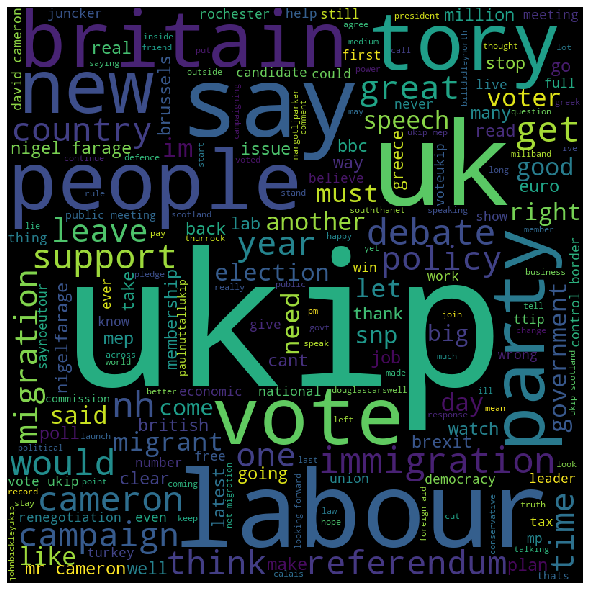

In [25]:
plot_word_cloud_for_category(classif_tweets,'EFDD')

Is the **Europe of Freedom and Direct Democracy** strongly connected with the UKIP? Of course it is, since EFDD has been chaired by [Nigel Farage](https://en.wikipedia.org/wiki/Nigel_Farage) who also happens to be the leader of UK Independence party ([UKIP](https://en.wikipedia.org/wiki/UK_Independence_Party))

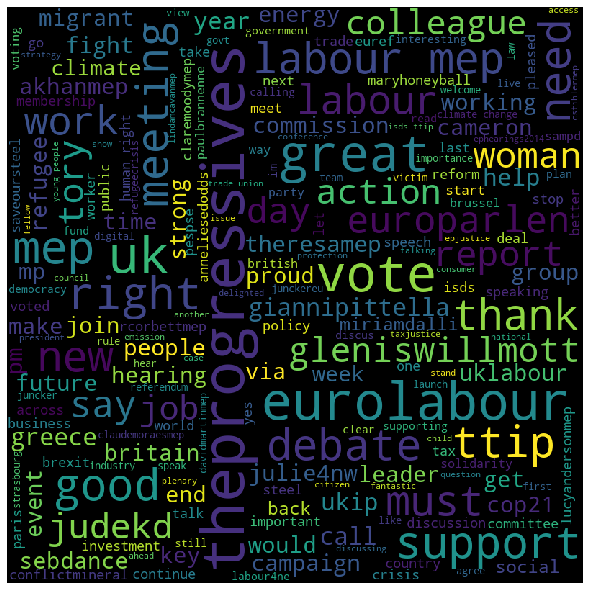

In [26]:
plot_word_cloud_for_category(classif_tweets,'S&D')

* These are the socialists & the Democrats.
* They are fighting for social justice, equality and sustainability. 
* The words we see on the cloud maybe refer to the **S&Ds outlook Brexit:** work with Labour for a closer EU-UK relationship or put the question back to the people

In [27]:
my_tags = list(classif_tweets.origMepGroupShort.unique())

It's time to split the data to training and testing. We are going give 70% for training and 30% for testing

In [28]:
X = classif_tweets.tweetText
y = classif_tweets.origMepGroupShort

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [29]:
#let's ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

nb = Pipeline(steps=[('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

scores = cross_val_score(nb, X, y, cv=5)
print('Accuracy for Naive Bayes Classifier %s' % accuracy_score(y_pred, y_test))
print('Accuracy for Naive Bayes Classifier with CV: ', scores.mean())
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy for Naive Bayes Classifier 0.5209501814582645
Accuracy for Naive Bayes Classifier with CV:  0.5076179850330218
              precision    recall  f1-score   support

        EFDD       0.71      0.20      0.31       435
         S&D       0.93      0.05      0.09       287
         ECR       0.55      0.91      0.69       754
        ALDE       0.74      0.50      0.60       500
         EPP       0.00      0.00      0.00        88
  Greens-EFA       0.92      0.04      0.08       297
     GUE-NGL       0.41      0.79      0.54       670

    accuracy                           0.52      3031
   macro avg       0.61      0.36      0.33      3031
weighted avg       0.63      0.52      0.45      3031



We only have achieved 50% accurancy. Let's try another method

## Stohastic Gradient Descend

In [32]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

scores = cross_val_score(sgd, X, y, cv=5)
print('Accuracy for SGD Classifier %s' % accuracy_score(y_pred, y_test))
print('Accuracy for SGD Classifier with CV: ', scores.mean())

print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy for SGD Classifier 0.604750907291323
Accuracy for SGD Classifier with CV:  0.5849257736345161
              precision    recall  f1-score   support

        EFDD       0.59      0.46      0.52       435
         S&D       0.62      0.28      0.38       287
         ECR       0.59      0.88      0.70       754
        ALDE       0.64      0.65      0.64       500
         EPP       0.74      0.42      0.54        88
  Greens-EFA       0.66      0.29      0.40       297
     GUE-NGL       0.59      0.66      0.62       670

    accuracy                           0.60      3031
   macro avg       0.63      0.52      0.54      3031
weighted avg       0.61      0.60      0.59      3031



It seems we did better, achieving 58%, which is 8% better than the Naive Bayes

## Multi Class Logistic Regression 

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

scores = cross_val_score(logreg, X, y, cv=5)
print('Accuracy for Logistic Regression Classifier %s' % accuracy_score(y_pred, y_test))
print('Accuracy for Logistic Regression Classifier with CV: ', scores.mean())
print(classification_report(y_test, y_pred, target_names=my_tags))

Accuracy for Logistic Regression Classifier 0.6093698449356648
Accuracy for Logistic Regression Classifier with CV:  0.5648231506940385
              precision    recall  f1-score   support

        EFDD       0.50      0.52      0.51       435
         S&D       0.45      0.38      0.41       287
         ECR       0.71      0.79      0.75       754
        ALDE       0.65      0.60      0.62       500
         EPP       0.69      0.48      0.56        88
  Greens-EFA       0.49      0.36      0.41       297
     GUE-NGL       0.61      0.70      0.65       670

    accuracy                           0.61      3031
   macro avg       0.59      0.55      0.56      3031
weighted avg       0.60      0.61      0.60      3031



## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfClf = Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                        ('random_forest', RandomForestClassifier())])
scores = cross_val_score(rfClf, X, y, cv=5, scoring='accuracy')

y_pred = logreg.predict(X_test)

print('CV Accuracy for RandomForest: ', scores.mean())
print(classification_report(y_test, y_pred, target_names=my_tags))

CV Accuracy for RandomForest:  0.492856270526317
              precision    recall  f1-score   support

        EFDD       0.50      0.52      0.51       435
         S&D       0.45      0.38      0.41       287
         ECR       0.71      0.79      0.75       754
        ALDE       0.65      0.60      0.62       500
         EPP       0.69      0.48      0.56        88
  Greens-EFA       0.49      0.36      0.41       297
     GUE-NGL       0.61      0.70      0.65       670

    accuracy                           0.61      3031
   macro avg       0.59      0.55      0.56      3031
weighted avg       0.60      0.61      0.60      3031



## XGBoost Classifier

In [35]:
import xgboost as xgb

xgb = Pipeline(steps=[('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(xgb, X, y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

Accuracy for XGBoost Classifier :  0.4874163546647658


## ADABoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
ada = Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                                ('ada', AdaBoostClassifier(n_estimators=100, random_state=0))])

scores = cross_val_score(ada, X, y, cv=5)
print('Accuracy for Tf-Idf & Ada Classifier : ', scores.mean())

Accuracy for Tf-Idf & Ada Classifier :  0.3868204235715073


pretty bad...

Since now, the most promissing Classifier is **SGDClassifier** so we will try to tune it's hyperparameters to get higher accurancy

## SGC with gridseach

In [234]:
from sklearn.model_selection import GridSearchCV
import pprint
from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])

t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3456 out of 3456 | elapsed: 15.1min finished


done in 912.179s

Best score: 0.581
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 80
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 2)


Run the SGDClassifier with tuned hyperparameters

In [51]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('vect', CountVectorizer(max_df=0.5, max_features=None, ngram_range=(1,2))), 
                      ('tfidf', TfidfTransformer(use_idf=True)),
                ('clf', SGDClassifier(alpha=1e-05, penalty='elasticnet', random_state=42, max_iter=80)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

scores = cross_val_score(sgd, X, y, cv=5)
print('Accuracy for SGD Classifier %s' % accuracy_score(y_pred, y_test))
print('Accuracy for SGD Classifier with CV: ', scores.mean())

print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy for SGD Classifier 0.6385589865399842
Accuracy for SGD Classifier with CV:  0.5944295628619065
              precision    recall  f1-score   support

        EFDD       0.53      0.57      0.55       359
         S&D       0.58      0.39      0.47       239
         ECR       0.68      0.85      0.76       616
        ALDE       0.69      0.61      0.65       417
         EPP       0.74      0.51      0.60        77
  Greens-EFA       0.56      0.36      0.44       252
     GUE-NGL       0.64      0.72      0.68       566

    accuracy                           0.64      2526
   macro avg       0.63      0.57      0.59      2526
weighted avg       0.63      0.64      0.63      2526



* We got the best one so far (59% accurancy) but we can do better than that
* We will keep the same parameters for ```CountVectorizer``` and ```TfidfTranformer``` and try to tune the Multi Class Logistic Regression Classifier

## LogReg with gridseach

In [249]:
from sklearn.model_selection import GridSearchCV
import pprint
from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, max_features=None, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', LogisticRegression()),
])

parameters = {
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ["none", "l2"],
    'clf__solver': ['lbfgs', 'sag', 'saga']
    
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])

t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 13.2min finished


done in 798.924s

Best score: 0.595
Best parameters set:
	clf__C: 100.0
	clf__penalty: 'none'
	clf__solver: 'saga'


In [253]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(steps=[('vect', CountVectorizer(max_df=0.5, max_features=None, ngram_range=(1,2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('clf', LogisticRegression(n_jobs=1, C=100, penalty='none', solver='saga'))
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

scores = cross_val_score(logreg, X, y, cv=5)
print('Accuracy for Logistic Regression Classifier %s' % accuracy_score(y_pred, y_test))
print('Accuracy for Logistic Regression Classifier with CV: ', scores.mean())
print(classification_report(y_test, y_pred, target_names=my_tags))

Accuracy for Logistic Regression Classifier 0.6357637743319037
Accuracy for Logistic Regression Classifier with CV:  0.5926471382335728
              precision    recall  f1-score   support

        EFDD       0.56      0.57      0.56       435
         S&D       0.62      0.33      0.43       287
         ECR       0.68      0.86      0.76       754
        ALDE       0.67      0.62      0.64       500
         EPP       0.76      0.42      0.54        88
  Greens-EFA       0.61      0.35      0.45       297
     GUE-NGL       0.61      0.73      0.66       670

    accuracy                           0.64      3031
   macro avg       0.64      0.55      0.58      3031
weighted avg       0.63      0.64      0.62      3031



The result is quite the same with the SGDClassifier. We managed to get almost **60% accurancy** with Cross Validation

Let's try an exhaustive Grid Search on SGDClassifier with more parameters

In [32]:
from sklearn.model_selection import GridSearchCV
import pprint
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

parameters = {
    'vect__max_df': (0.5 ,0.6, 0.7, 0.8, 1.0),
    'vect__min_df': (10, 12, 14, 16),
    'vect__max_features': (None, 5000, 7500, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001, 0.0000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80, 100, 150)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])

t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

done in 13516.003s

Best score: 0.519
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 100
	clf__penalty: 'l2'
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 10
	vect__ngram_range: (1, 2)


We didn't get something out of it (even if we waited for 210 mins), so we stick with the SGDClassifier and the almost 60% accurancy